<a href="https://colab.research.google.com/github/eunzzae/KaggleStudy_MustHave/blob/main/Chap08_%EC%95%88%EC%A0%84_%EC%9A%B4%EC%A0%84%EC%9E%90_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 학습 개요
### 1) 학습목표  
: 실제 기업 데이터를 활용한 안전 운전자 예측 경진대회   
캐글에서 실제로 활용되는 여러가지 고급 모델링 기법 활용

### 2) 학습 순서  
: 경진대회 이해 → 탐색적 데이터 분석 → 베이스라인 모델(Light GBM) → 성능개선(앙상블) → 성능개선(XGBoost) → 성능개선(LightGBM + 피처엔지니어링 강화, 하이퍼파라미터 최적화)

### 3) 학습 키워드  
* 유형 및 평가지표 : 이진분류, 정규화된 지니계수  
* 탐색적 데이터 분석 : 피처 요약표 응용, 결측값 시각화, 결측값 처리  
* 머신러닝 모델 : OOF 예측, LightGBM, XGBoost, 앙상블  
* 피처 엔지니어링 : 창의적 피처 엔지니어링  
* 하이퍼파라미터 최적화 : 베이지안 최적화   

# 1. 경진대회 이해   

* 주최측 : '포르투 세구로' 브라질의 보험회사가 주최
* 주어진 데이터 : 포르투 세구로의 고객 데이터 (결측값은 -1로 기록됨)  
* 타깃값 : 운전자가 보험금을 청구하지 않으면 0, 보험금을 청구하면 1 (이진분류)  
* 운전자가 보험금을 청구할 확률을 예측하는 모델 개발   
→ 안전운전자(사고 낼 가능성 낮음)에게 보험료를 적게 청구, 위험운전자(사고 낼 가능성 높음)에게 보험료 높게 청구   

캐글대회 : https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction

# 2. 탐색적 데이터 분석

# 2-1) 데이터 둘러보기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# 데이터 경로
data_path = '/content/drive/MyDrive/[캐글] 스터디_musthave/data/poroto_insurance/'

train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

In [4]:
train.shape, test.shape

((595212, 58), (892816, 57))

In [5]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [6]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [7]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [8]:
train.info()
# coulumn에 일정한 형식이 있음
# ps_[분류]_[분류별 일련번호]_[데이터종류]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

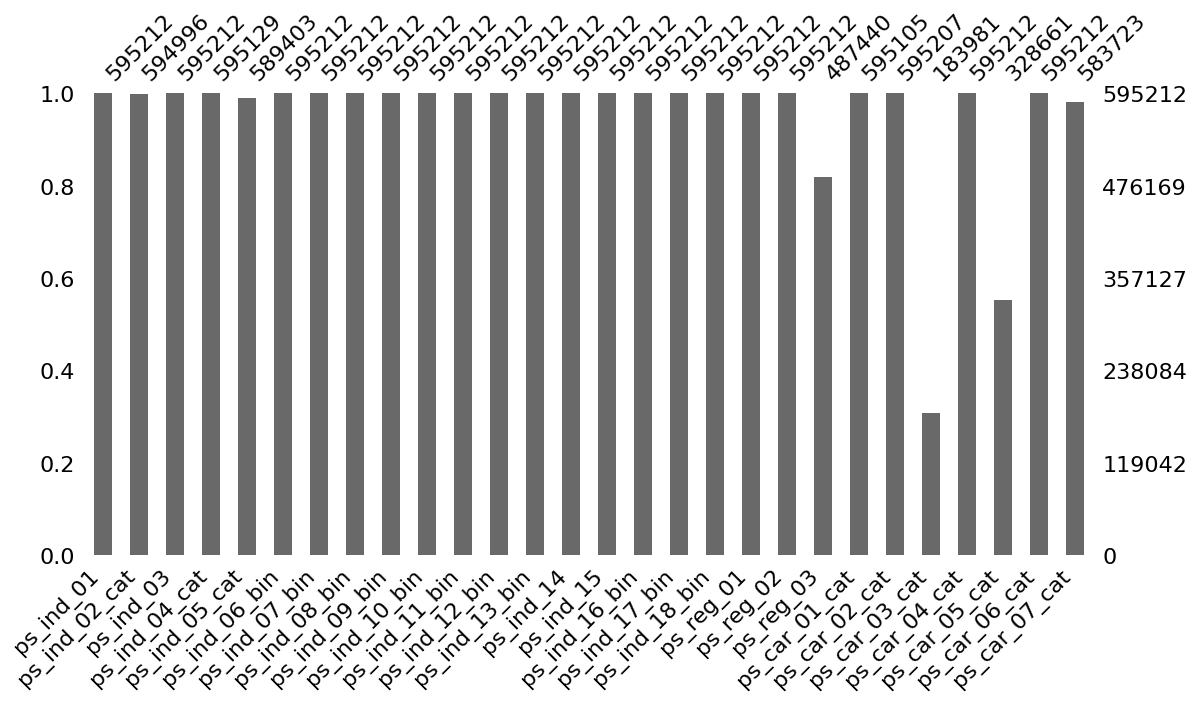

In [9]:
import numpy as np
import missingno as msno # 결측값을 시각화하는 패키지

# 훈련 데이터 복사본에서 -1을 np.NaN로 변환
train_copy = train.copy().replace(-1, np.NaN)

# 결측값 시각화(처음 28개만)
msno.bar(df=train_copy.iloc[:, 1:29], figsize=(13, 6));

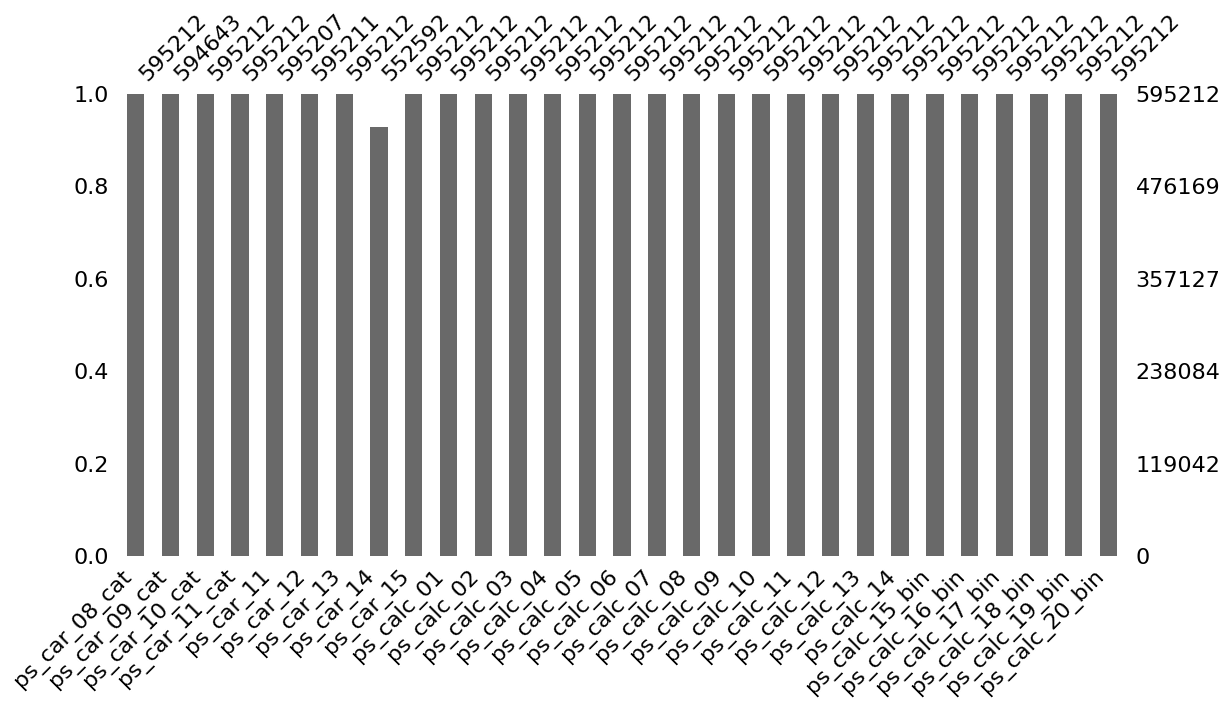

In [10]:
msno.bar(df=train_copy.iloc[:, 29:], figsize=(13, 6));

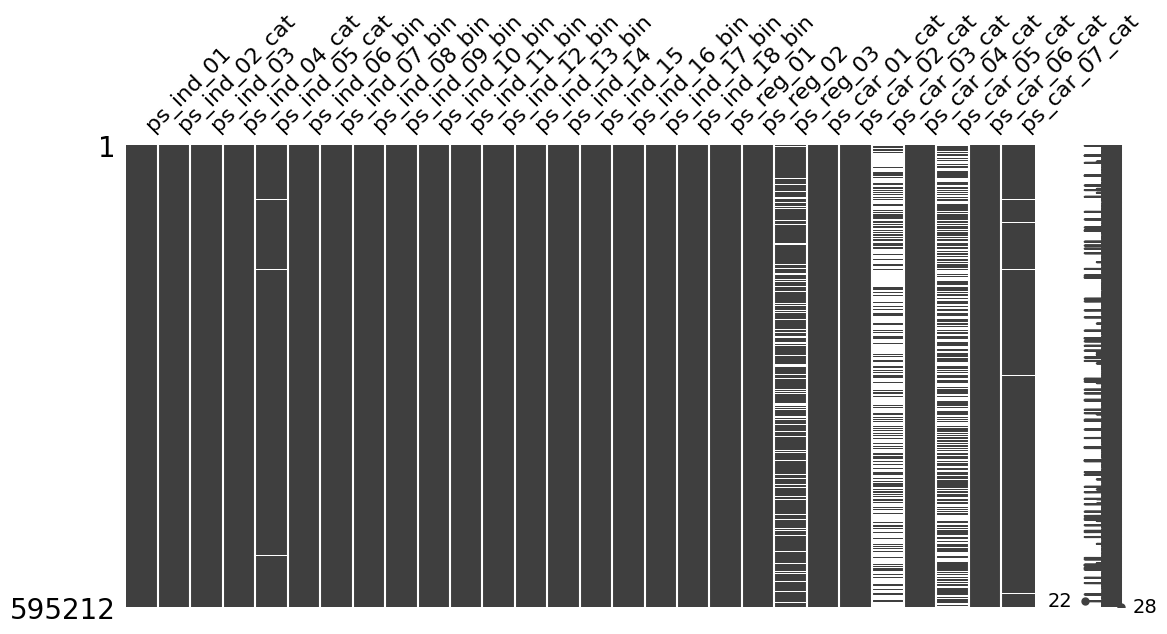

In [11]:
msno.matrix(df=train_copy.iloc[:, 1:29], figsize=(13, 6)); # matrix 타입으로 결측값 시각화(결측값 없는 열 개수 : 22, 전체 열 개수 : 28)

## 1) 피처 요약표


In [12]:
def resumetable(df):
  print(f'데이터셋 형상 : {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
  summary['결측값 개수'] = (df == -1).sum().values # 피처별 -1 개수
  summary['고윳값 개수'] = df.nunique().values
  summary['데이터 종류'] = None
  for col in df.columns:
    if 'bin' in col or col == 'target':
      summary.loc[col, '데이터 종류'] = '이진형'
    elif 'cat' in col:
      summary.loc[col, '데이터 종류'] = '명목형'
    elif df[col].dtype == float:
      summary.loc[col, '데이터 종류'] = '연속형'
    elif df[col].dtype == int:
      summary.loc[col, '데이터 종류'] = '순서형'
  return summary

In [13]:
summary = resumetable(train)
summary

데이터셋 형상 : (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [14]:
summary[summary['데이터 종류'] == '명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [15]:
summary[summary['데이터 종류'] == 'float64'].index

Index([], dtype='object')

# 2-2) 데이터 시각화

In [16]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

## 1) 타깃값 분포

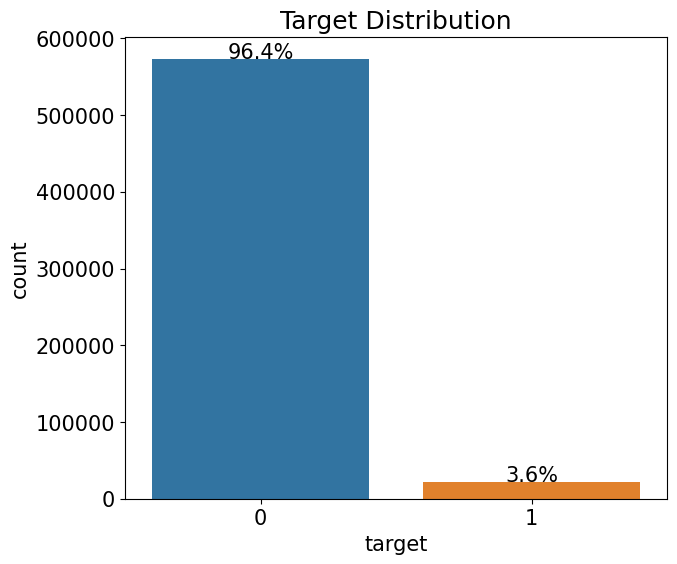

In [17]:
def write_percent(ax, total_size):
  '''도형 객체를 순회하며 막대 그래프 상단에 타깃값 비율 표시'''
  for patch in ax.patches:
    height = patch.get_height()         # 도형 높이(데이터 개수)
    width = patch.get_width()           # 도형 너비
    left_coord = patch.get_x()          # 도형 왼쪽 테두리의 x축 위치
    percent = height/total_size*100     # 타깃값 비율

    # (x, y) 좌표에 텍스트 입력
    ax.text(left_coord + width/2.0,     # x축 위치
            height + total_size*0.001,  # y축 위치
            '{:1.1f}%'.format(percent), # 입력 테스트
            ha='center')                # 가운데 정렬

mpl.rc('font', size=15)
plt.figure(figsize=(7,6))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train))           # 비율 표시
ax.set_title('Target Distribution');

## 2) 이진 피처

In [18]:
import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12, 18)):
  mpl.rc('font', size=9)
  plt.figure(figsize=size)                      # 전체 Figure 크기 설정
  grid = gridspec.GridSpec(num_rows, num_cols)  # 서브플롯 배치
  plt.subplots_adjust(wspace=0.3, hspace=0.3)   # 서브플롯 좌우/상하 여백 설정

  for idx, feature in enumerate(features):
    ax= plt.subplot(grid[idx])
    # ax 축에 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
    sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax)

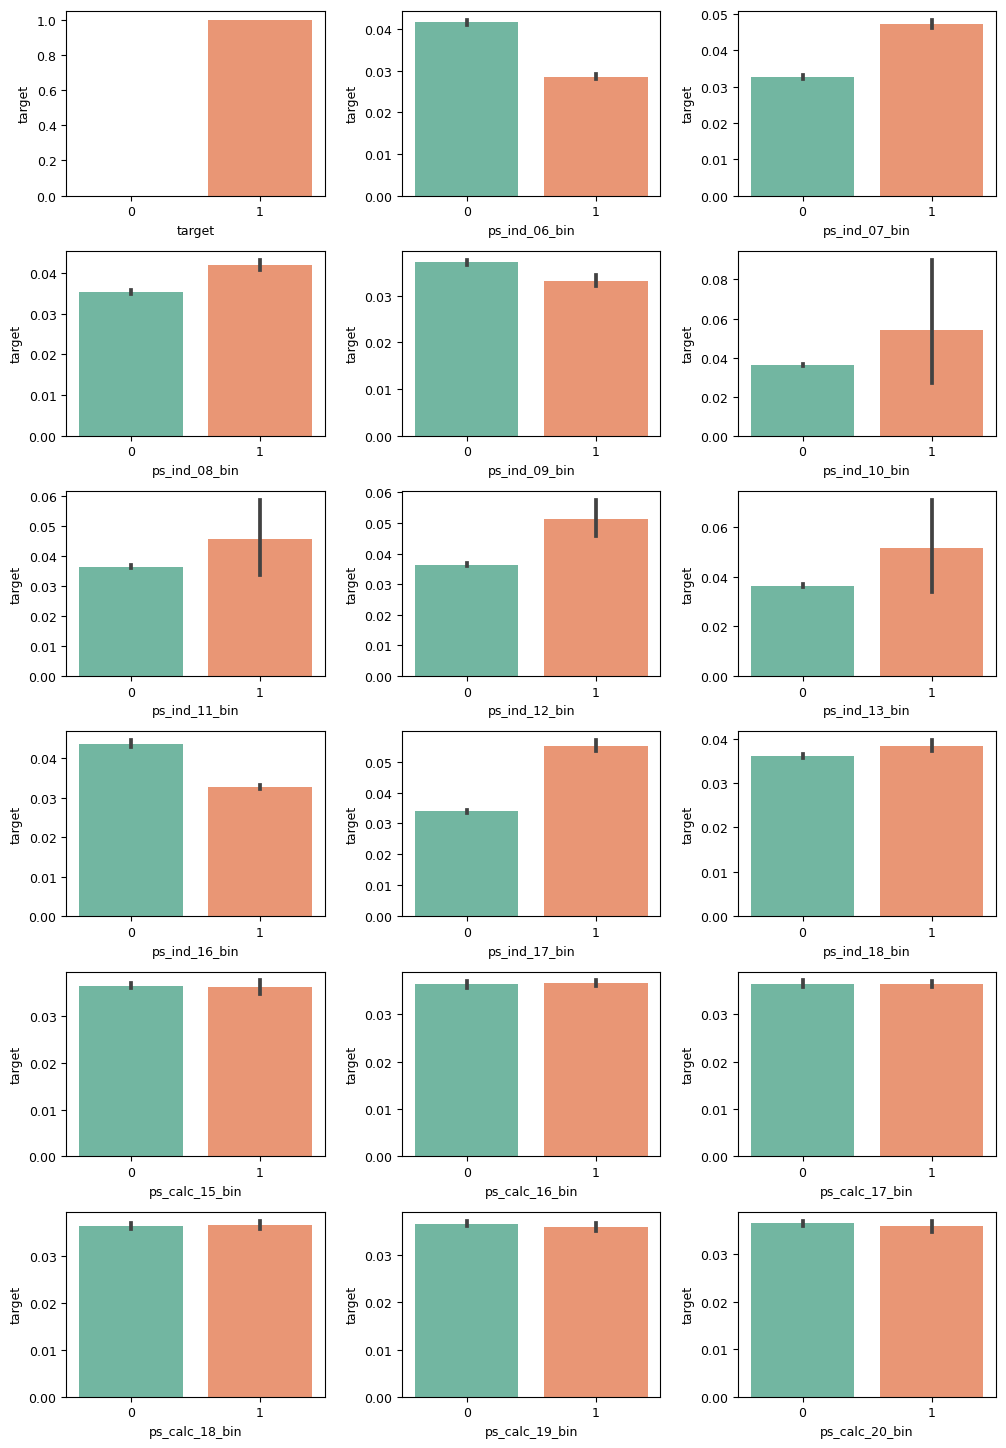

In [19]:
bin_features = summary[summary['데이터 종류'] == '이진형'].index # 이진 피처
# 이진 피처 고윳값별 타깃값 1 비율을 막대 그래프로 그리기
plot_target_ratio_by_features(train, bin_features, 6, 3)         # 6행 3열 배치

## 3) 명목형 피처

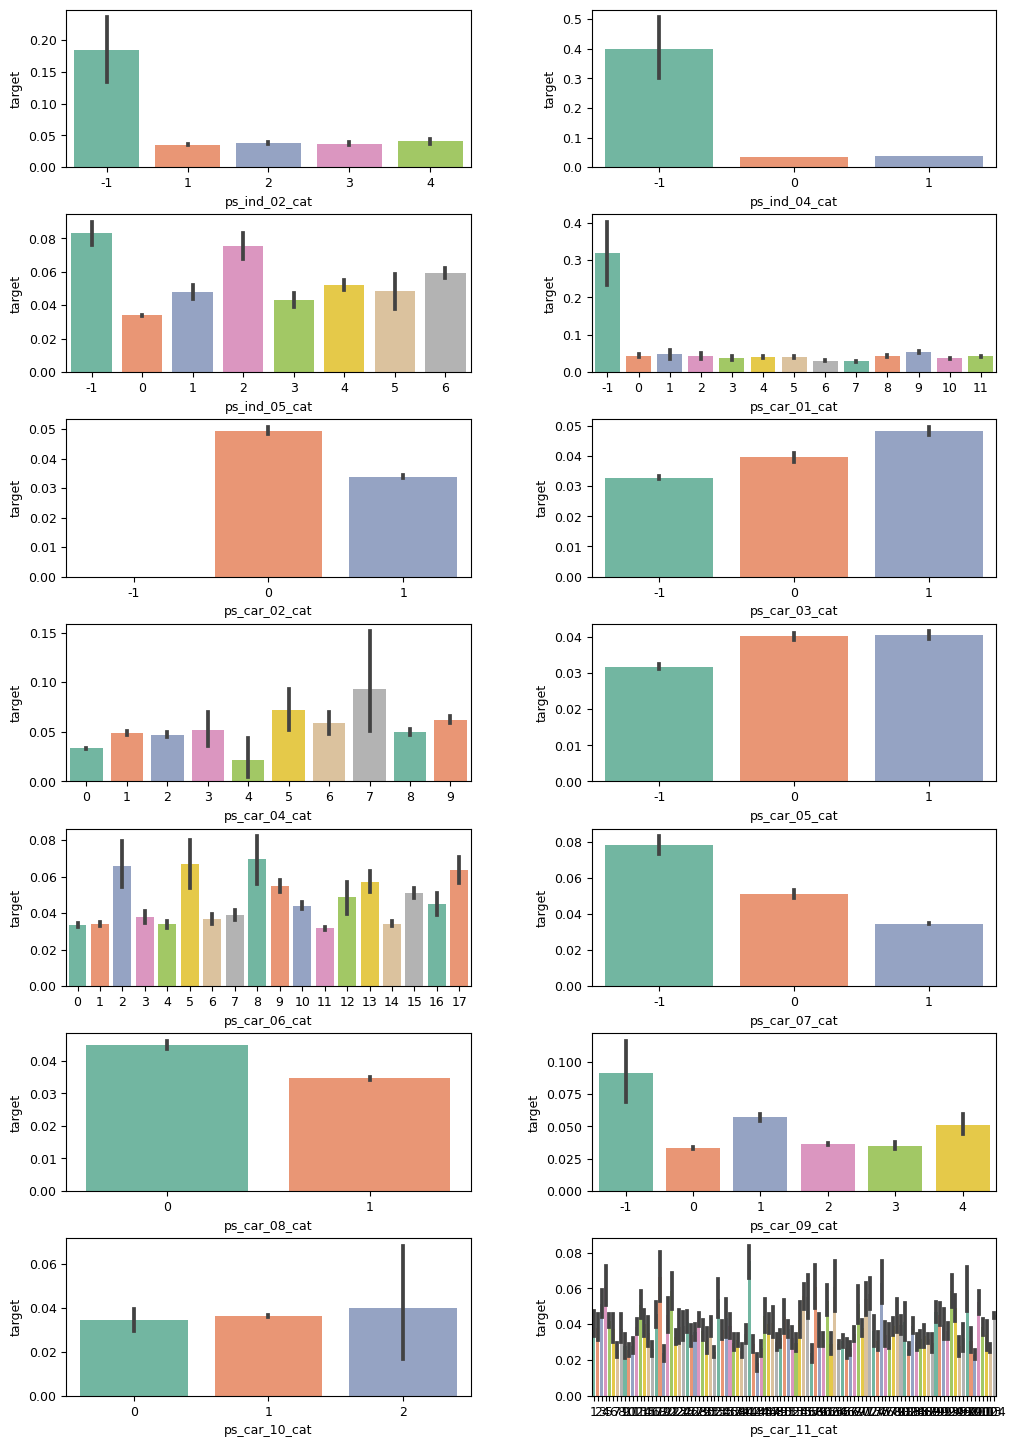

In [20]:
nom_features = summary[summary['데이터 종류'] == '명목형'].index  # 명목형 피처
plot_target_ratio_by_features(train, nom_features, 7, 2)          # 7행 2열

## 4) 순서형 피처

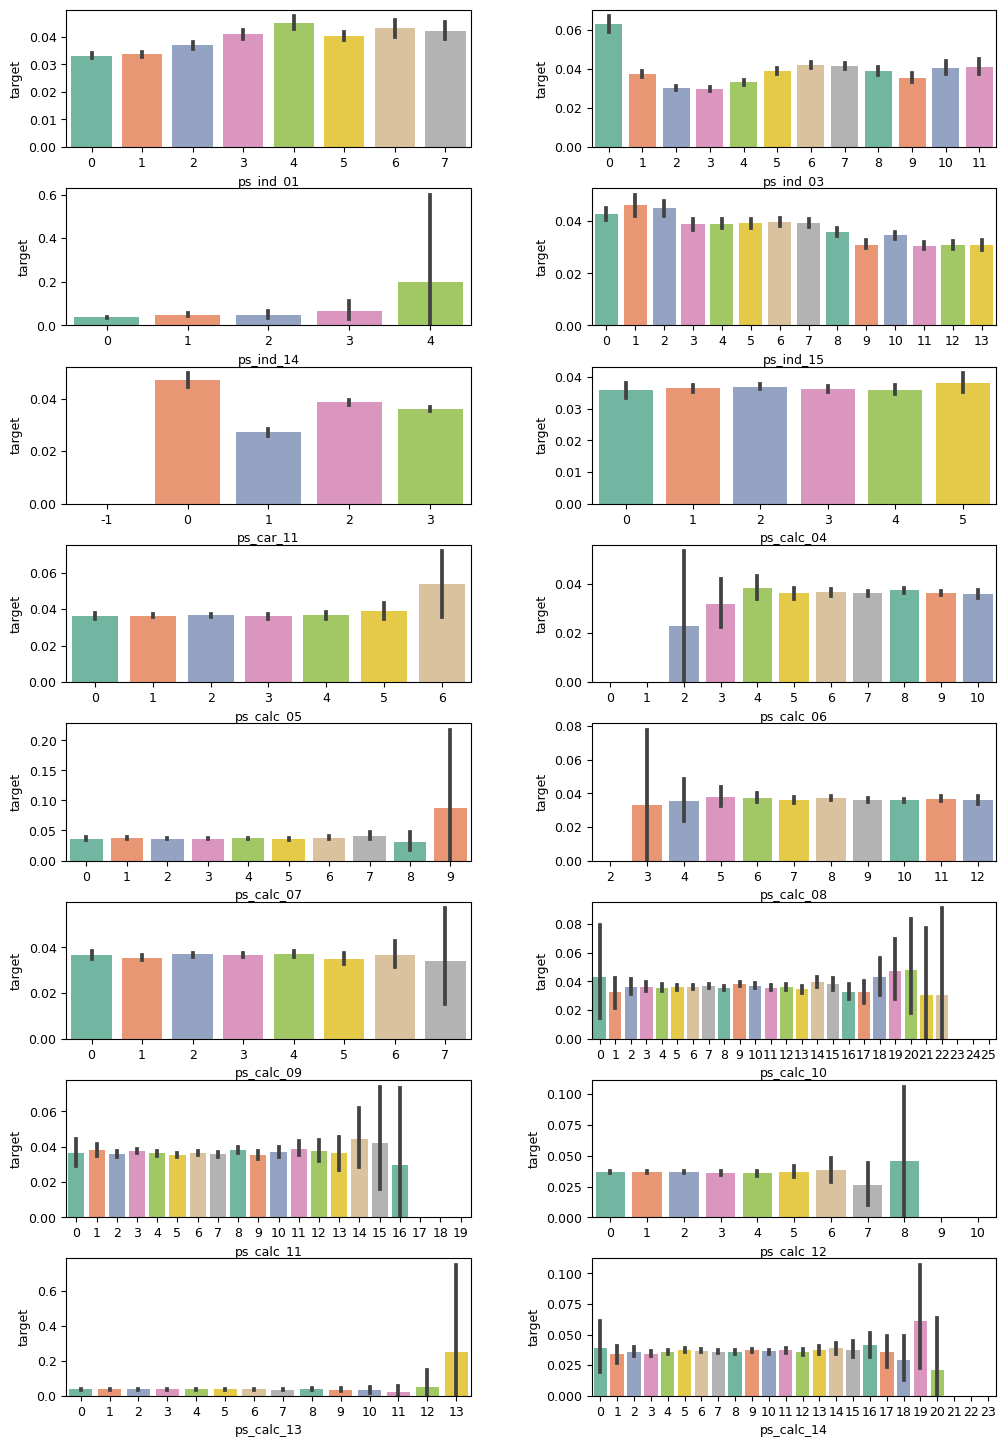

In [21]:
ord_features = summary[summary['데이터 종류'] == '순서형'].index  # 순서형 피처
plot_target_ratio_by_features(train, ord_features, 8, 2)          # 8행 2열

## 5) 연속형 피처

In [22]:
pd.cut([1.0, 1.5, 2.1, 2.7, 3.5, 4.0], 3)

[(0.997, 2.0], (0.997, 2.0], (2.0, 3.0], (2.0, 3.0], (3.0, 4.0], (3.0, 4.0]]
Categories (3, interval[float64, right]): [(0.997, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

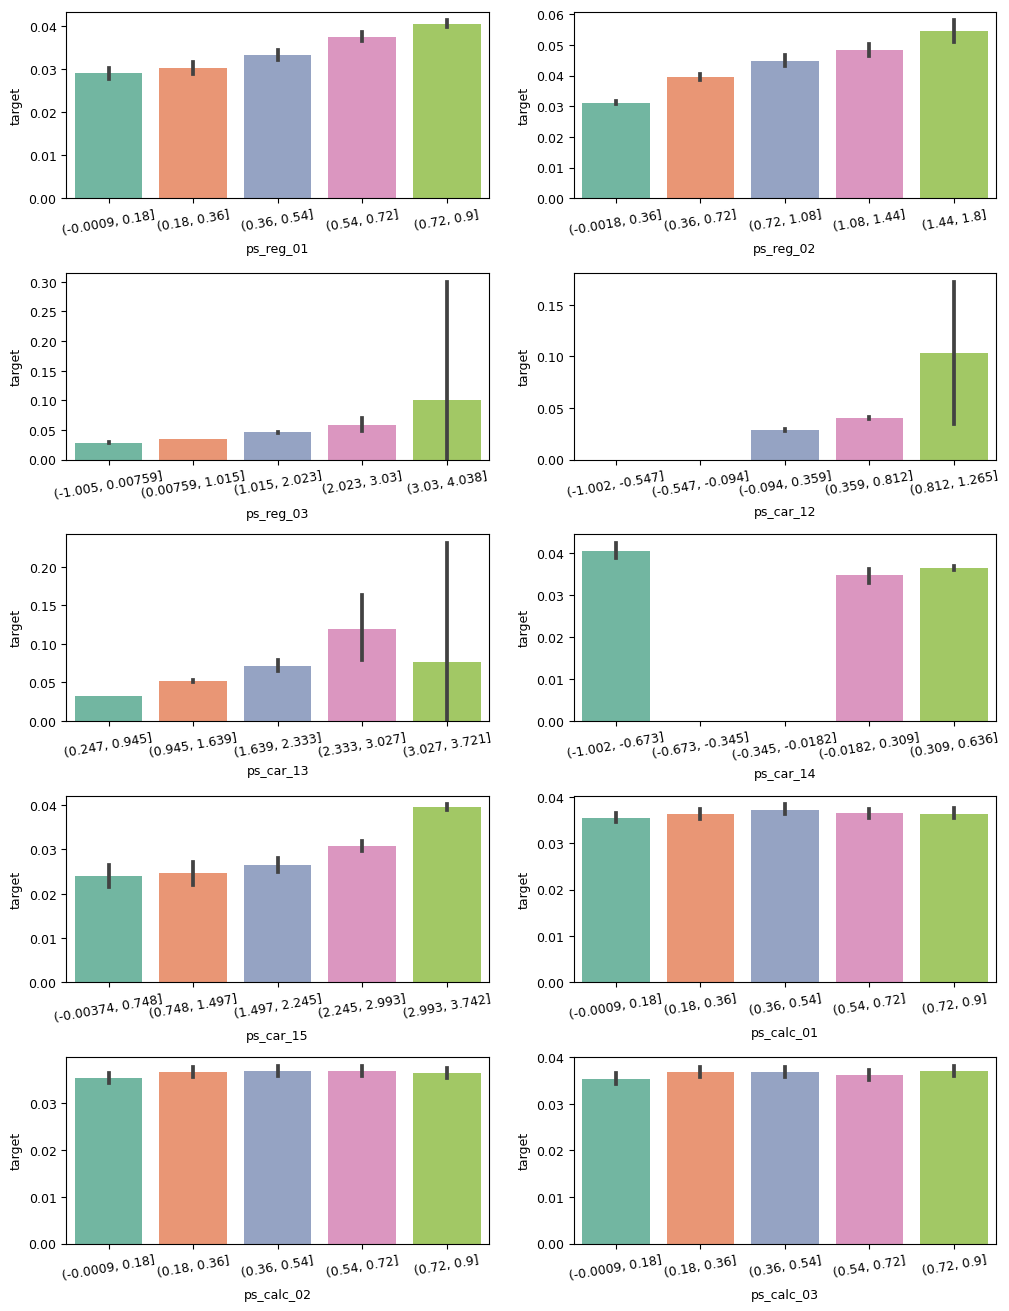

In [23]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index             # 연속형 피처

plt.figure(figsize=(12, 16))                                                    # Figure 크기 설정
grid = gridspec.GridSpec(5, 2)                                                # GridSpec 객체 생성
plt.subplots_adjust(wspace=0.2, hspace=0.4)                                   # 서브플롯 간 여백 설정

for idx, cont_features in enumerate(cont_features):
  # 값을 5개 구간으로 나누기
  train[cont_features] = pd.cut(train[cont_features], 5)

  ax = plt.subplot(grid[idx])                                                 # 분포도를 그릴 서브플롯 설정
  sns.barplot(x=cont_features, y='target', data=train, palette='Set2', ax=ax)
  ax.tick_params(axis='x', labelrotation=10)                                  # x축 라벨 회전

### 피처 간 상관관계 파악을 위한 히트맵 그리기

In [25]:
train_copy = train_copy.dropna() # np.NaN 값 삭제

In [53]:
plt.figure(figsize=(10, 8))
cont_corr = train_copy[cont_features].corr()
sns.heatmap(cont_corr, annot=True, cmap='OrRd')

TypeError: ignored

<Figure size 1000x800 with 0 Axes>

# 2-3) 베이스라인 모델

In [27]:
import pandas as pd

# 데이터 경로
data_path = '/content/drive/MyDrive/[캐글] 스터디_musthave/data/poroto_insurance/'

train = pd.read_csv(data_path + 'train.csv', index_col = 'id')
test = pd.read_csv(data_path + 'test.csv', index_col = 'id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col = 'id')

## 1) 피처엔지니어링

### 데이터 합치기

In [28]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

In [29]:
all_features = all_data.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

### 명목형 피처 원-핫 인코딩

In [30]:
from sklearn.preprocessing import OneHotEncoder
# 명목형 피처 추출
cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성
# 인코딩
encoded_cat_matrix =onehot_encoder.fit_transform(all_data[cat_features])

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

### 필요없는 피처 제거

In [31]:
# 추가로 제거할 피처
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# '1) 명목형 피처, 2) calc 분류의 피처, 3) 추가 제거할 피처'를 제외한 피처
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and
                          'calc' not in feature and
                          feature not in drop_features)]

In [32]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr')

### 데이터 나누기

In [33]:
num_train = len(train) # 훈련 데이터 개수

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

## 2) 평가지표 계산 함수 작성

### 정규화 지니계수 계산 함수

In [34]:
import numpy as np

def eval_gini(y_true, y_pred):
  # 실제값과 예측값의 크기가 서로 같은지 확인(값이 다르면 오류 발생)
  assert y_true.shape == y_pred.shape

  n_samples = y_true.shape[0]                         # 데이터 개수
  L_mid = np.linspace(1/n_samples, 1, n_samples)      # 대각선 값

  # 1) 예측값에 대한 지니계수
  pred_order = y_true[y_pred.argsort()]               # y_pred 크기순으로 y_true 값 정렬
  L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
  G_pred = np.sum(L_mid - L_pred)                     # 예측값에 대한 지니계수

  # 2) 예측이 완벽할 때 지니계수
  ture_order = y_true[y_true.argsort()]               # y_true 크기순으로 y_true 값 정렬
  L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
  G_true = np.sum(L_mid - L_true)                     # 예측이 완벽할 때 지니계수

  # 정규화된 지니계수
  return G_pred / G_true

In [35]:
# LightGBM gini() 함수
def gini(preds, dtrain):
  labels = dtrain.get_label()
  return 'gini', eval_gini(labels, preds), True # 반환값

## 3) 모델 훈련 및 성능 검증

In [36]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [37]:
params={'objective':'binary',
        'learning_rate': 0.01,
        'force_row_wise' : True,
        'random_state':42}

In [38]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0])
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0])